In [ ]:
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
import random
import matplotlib.patheffects as PathEffects

In [ ]:
from keras.layers import Input, Conv2D, Lambda, Dense, Flatten,MaxPooling2D, concatenate
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam #stochastic gradient descent
from keras.losses import binary_crossentropy
import os
import pickle
import matplotlib.pyplot as plt

In [ ]:
from itertools import permutations

In [ ]:
import seaborn as sns

In [ ]:
from keras.datasets import mnist
from sklearn.manifold import TSNE #stochastic neighbour embedding

In [ ]:
from sklearn.svm import SVC

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
def scatter(x, labels, subtitle=None):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.savefig(subtitle)

In [ ]:
x_train_flat = x_train.reshape(-1,784)
x_test_flat = x_test.reshape(-1,784)

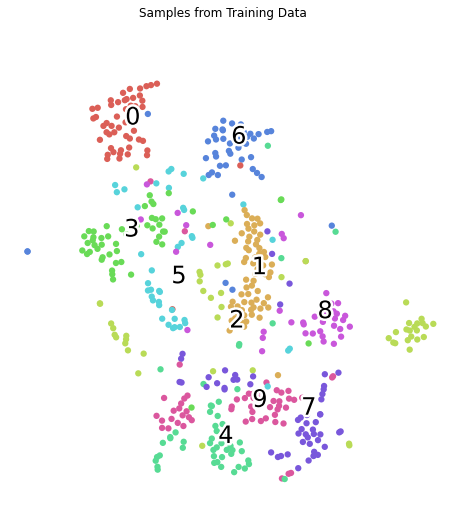

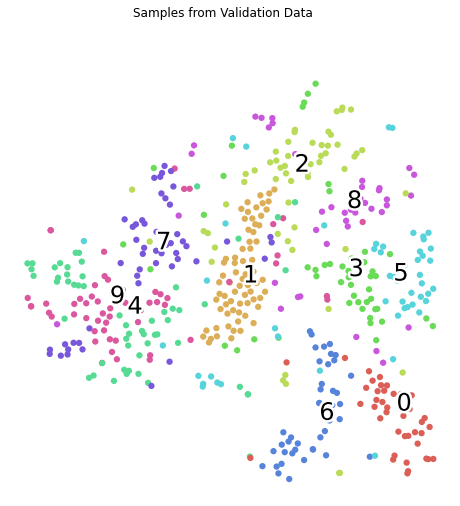

In [ ]:
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(x_train_flat[:512])
scatter(train_tsne_embeds, y_train[:512], "Samples from Training Data")

eval_tsne_embeds = tsne.fit_transform(x_test_flat[:512])
scatter(eval_tsne_embeds, y_test[:512], "Samples from Validation Data")

In [ ]:
Classifier_input = Input((784,))
Classifier_output = Dense(10, activation='softmax')(Classifier_input)
Classifier_model = Model(Classifier_input, Classifier_output)

In [ ]:
from sklearn.preprocessing import LabelBinarizer

In [ ]:
le = LabelBinarizer()

In [ ]:
y_train_onehot = le.fit_transform(y_train)
y_test_onehot = le.transform(y_test)

In [ ]:
Classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
Classifier_model.fit(x_train_flat,y_train_onehot, validation_data=(x_test_flat,y_test_onehot),epochs=10)

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 19.1460 - accuracy: 0.7615 - val_loss: 6.7665 - val_accuracy: 0.8751
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 6.0803 - accuracy: 0.8773 - val_loss: 5.9622 - val_accuracy: 0.8882
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 5.6109 - accuracy: 0.8854 - val_loss: 6.0829 - val_accuracy: 0.8694
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 5.1892 - accuracy: 0.8885 - val_loss: 5.2993 - val_accuracy: 0.8939
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 5.3296 - accuracy: 0.8860 - val_loss: 6.4229 - val_accuracy: 0.8647
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 5.1772 - accuracy: 0.8897 - val_loss: 6.3102 - val_accuracy: 0.8783
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 5.1226 - accuracy: 0.8891 - val_loss: 5.0220 - val_accuracy

In [ ]:
def generate_triplet(x,y,testsize=0.3,ap_pairs=10,an_pairs=10):
    data_xy = tuple([x,y])

    trainsize = 1-testsize

    triplet_train_pairs = []
    triplet_test_pairs = []
    for data_class in sorted(set(data_xy[1])):

        same_class_idx = np.where((data_xy[1] == data_class))[0]
        diff_class_idx = np.where(data_xy[1] != data_class)[0]
        A_P_pairs = random.sample(list(permutations(same_class_idx,2)),k=ap_pairs) #Generating Anchor-Positive pairs
        Neg_idx = random.sample(list(diff_class_idx),k=an_pairs)
        

        #train
        A_P_len = len(A_P_pairs)
        Neg_len = len(Neg_idx)
        for ap in A_P_pairs[:int(A_P_len*trainsize)]:
            Anchor = data_xy[0][ap[0]]
            Positive = data_xy[0][ap[1]]
            for n in Neg_idx:
                Negative = data_xy[0][n]
                triplet_train_pairs.append([Anchor,Positive,Negative])               
        #test
        for ap in A_P_pairs[int(A_P_len*trainsize):]:
            Anchor = data_xy[0][ap[0]]
            Positive = data_xy[0][ap[1]]
            for n in Neg_idx:
                Negative = data_xy[0][n]
                triplet_test_pairs.append([Anchor,Positive,Negative])    
                
    return np.array(triplet_train_pairs), np.array(triplet_test_pairs)

In [ ]:
X_train, X_test = generate_triplet(x_train_flat,y_train, ap_pairs=150, an_pairs=150,testsize=0.2)

triple NN

In [ ]:
def triplet_loss(y_true, y_pred, alpha = 0.4):
    """
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor data
            positive -- the encodings for the positive data (similar to anchor)
            negative -- the encodings for the negative data (different from anchor)
    Returns:
    loss -- real number, value of the loss
    """
    print('y_pred.shape = ',y_pred)
    
    total_lenght = y_pred.shape.as_list()[-1]
#     print('total_lenght=',  total_lenght)
#     total_lenght =12
    
    anchor = y_pred[:,0:int(total_lenght*1/3)]
    positive = y_pred[:,int(total_lenght*1/3):int(total_lenght*2/3)]
    negative = y_pred[:,int(total_lenght*2/3):int(total_lenght*3/3)]

    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)

    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)

    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
 
    return loss

In [ ]:
def create_base_network(in_dims):
    """
    Base network to be shared.
    """
    model = Sequential()
    model.add(Conv2D(128,(7,7),padding='same',input_shape=(in_dims[0],in_dims[1],in_dims[2],),activation='relu',name='conv1'))
    model.add(MaxPooling2D((2,2),(2,2),padding='same',name='pool1'))
    model.add(Conv2D(256,(5,5),padding='same',activation='relu',name='conv2'))
    model.add(MaxPooling2D((2,2),(2,2),padding='same',name='pool2'))
    model.add(Flatten(name='flatten'))
    model.add(Dense(4,name='embeddings'))
    # model.add(Dense(600))
    
    return model

In [ ]:
adam_optim = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)

In [ ]:
anchor_input = Input((28,28,1, ), name='anchor_input')
positive_input = Input((28,28,1, ), name='positive_input')
negative_input = Input((28,28,1, ), name='negative_input')

# Shared embedding layer for positive and negative items
Shared_DNN = create_base_network([28,28,1,])


encoded_anchor = Shared_DNN(anchor_input)
encoded_positive = Shared_DNN(positive_input)
encoded_negative = Shared_DNN(negative_input)


merged_vector = concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1, name='merged_layer')

model = Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)
model.compile(loss=triplet_loss, optimizer=adam_optim)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 4)            876036      anchor_input[0][0]               
                                                                 positive_input[0][0]       

In [ ]:
Anchor = X_train[:,0,:].reshape(-1,28,28,1)
Positive = X_train[:,1,:].reshape(-1,28,28,1)
Negative = X_train[:,2,:].reshape(-1,28,28,1)
Anchor_test = X_test[:,0,:].reshape(-1,28,28,1)
Positive_test = X_test[:,1,:].reshape(-1,28,28,1)
Negative_test = X_test[:,2,:].reshape(-1,28,28,1)

Y_dummy = np.empty((Anchor.shape[0],300))
Y_dummy2 = np.empty((Anchor_test.shape[0],1))

model.fit([Anchor,Positive,Negative],y=Y_dummy,validation_data=([Anchor_test,Positive_test,Negative_test],Y_dummy2), batch_size=512, epochs=500)

In [ ]:
trained_model = Model(inputs=anchor_input, outputs=encoded_anchor)

In [ ]:
trained_model.load_weights('triplet_model_MNIST.hdf5')

In [ ]:
tsne = TSNE()
X_train_trm = trained_model.predict(x_train[:512].reshape(-1,28,28,1))
X_test_trm = trained_model.predict(x_test[:512].reshape(-1,28,28,1))
train_tsne_embeds = tsne.fit_transform(X_train_trm)
eval_tsne_embeds = tsne.fit_transform(X_test_trm)

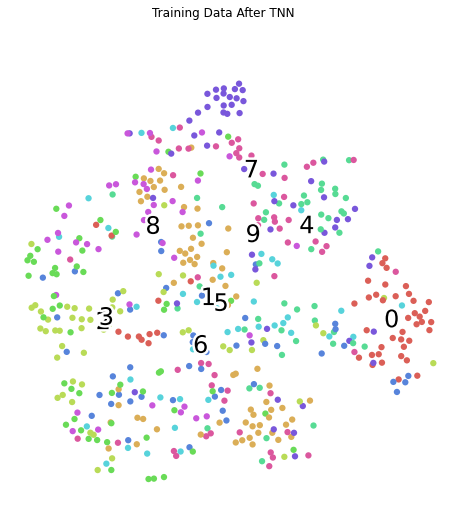

In [ ]:
scatter(train_tsne_embeds, y_train[:512], "Training Data After TNN")

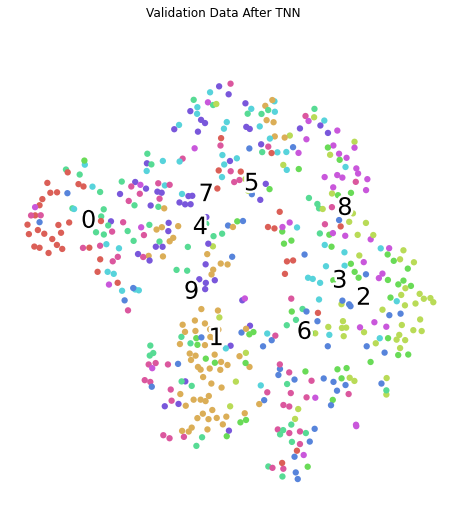

In [ ]:
scatter(eval_tsne_embeds, y_test[:512], "Validation Data After TNN")

In [ ]:

X_train_trm = trained_model.predict(x_train.reshape(-1,28,28,1))
X_test_trm = trained_model.predict(x_test.reshape(-1,28,28,1))

Classifier_input = Input((4,))
Classifier_output = Dense(10, activation='softmax')(Classifier_input)
Classifier_model = Model(Classifier_input, Classifier_output)


Classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

Classifier_model.fit(X_train_trm,y_train_onehot, validation_data=(X_test_trm,y_test_onehot),epochs=10)

Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 5.3097 - accuracy: 0.1655 - val_loss: 1.7304 - val_accuracy: 0.3955
Epoch 2/10
1875/1875 [==============================] - 2s 1ms/step - loss: 1.7264 - accuracy: 0.3991 - val_loss: 1.6919 - val_accuracy: 0.4186
Epoch 3/10
1875/1875 [==============================] - 2s 1ms/step - loss: 1.6946 - accuracy: 0.4139 - val_loss: 1.6718 - val_accuracy: 0.4263
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 1.6896 - accuracy: 0.4139 - val_loss: 1.6628 - val_accuracy: 0.4290
Epoch 5/10
1875/1875 [==============================] - 2s 1ms/step - loss: 1.6805 - accuracy: 0.4158 - val_loss: 1.6538 - val_accuracy: 0.4319
Epoch 6/10
1875/1875 [==============================] - 2s 1ms/step - loss: 1.6692 - accuracy: 0.4212 - val_loss: 1.6492 - val_accuracy: 0.4293
Epoch 7/10
1875/1875 [==============================] - 2s 1ms/step - loss: 1.6624 - accuracy: 0.4206 - val_loss: 1.6530 - val_accuracy: